# Load Library

In [1]:
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/arya.ashish/minet.zip"
!unzip -qo minet.zip 
!rm minet.zip

--2020-11-19 05:13:36--  https://cainvas-static.s3.amazonaws.com/media/user_data/arya.ashish/minet.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.64.116
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.64.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123734481 (118M) [application/x-zip-compressed]
Saving to: ‘minet.zip’

minet.zip           100%[===================>] 118.00M  62.6MB/s    in 1.9s    

2020-11-19 05:13:38 (62.6 MB/s) - ‘minet.zip’ saved [123734481/123734481]



In [5]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

import cv2
from keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

# Load Data and Get Insight

In [3]:
root_folder = 'minet/train'
target_label = ['biotite', 'bornite', 'chrysocolla', 'malachite', 
               'muscovite', 'pyrite', 'quartz']


In [6]:
dataset = ImageFolder(root_folder, transform=transforms.ToTensor())
print('Data size: ',len(dataset))
dataset.classes

Data size:  350


['biotite',
 'bornite',
 'chrysocolla',
 'malachite',
 'muscovite',
 'pyrite',
 'quartz']

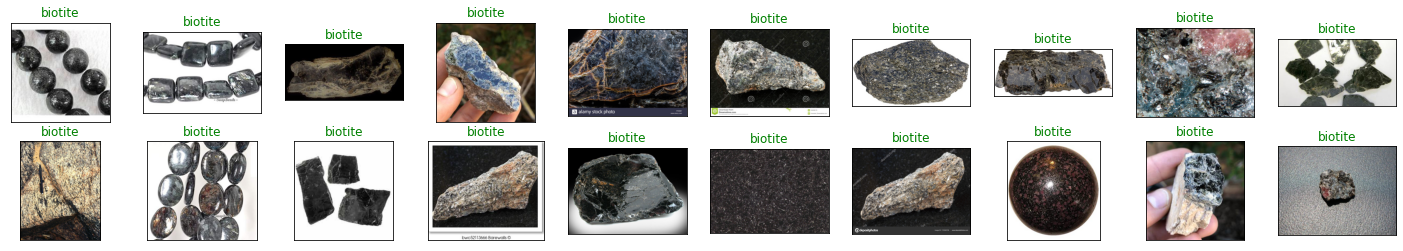

In [7]:
#check images of the dataset for first 20 images
fig = plt.figure(figsize=(25, 4))

for i in range(20):
    image, label = dataset[i]
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks = [])
    ax.imshow(image.permute(1,2,0))
    ax.set_title(target_label[label], color='green')

In [8]:
#count number for each label
count = {}

for i in range(len(dataset)):
    _, labels = dataset[i]
    label = target_label[labels]
    if label not in count:
        count[label] = 1
    elif label in count:
        count[label] += 1

#insert count into dataframe
df = pd.DataFrame(count, index=np.arange(1))
df = df.transpose().reset_index()
df.columns = ['Mineral', 'count']
df

,Mineral,count
0,biotite,50
1,bornite,50
2,chrysocolla,50
3,malachite,50
4,muscovite,50
5,pyrite,50
6,quartz,50


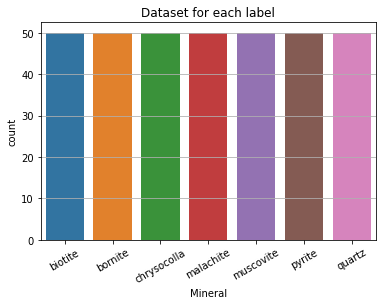

In [9]:
#plot barplot for the sake of easy to read
sns.barplot(df['Mineral'], df['count'])
plt.title('Dataset for each label');
plt.xticks(rotation=30)
plt.grid(axis='y')

In [10]:
#check image size for all datasets
# torch.FloatTensor of shape (C x H x W) 
height = []
width = []
for i in range(len(dataset)):
    image, label = dataset[i]
    height.append(image.size(1))
    width.append(image.size(2))
print(f"maximum_height:{np.max(height)} \tminimum_height:{np.min(height)} \tmean_height:{np.mean(height)}")
print(f"maximum_width:{np.max(width)} \tminimum_width:{np.min(width)} \tmean_width:{np.mean(width)}")

maximum_height:5669 	minimum_height:148 	mean_height:722.6914285714286
maximum_width:5184 	minimum_width:144 	mean_width:826.4685714285714


In [11]:
data_path = "minet"
# Data agumentation on train and test

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
# create dataset train
training_set = train_datagen.flow_from_directory(data_path + '/train',
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical',
                                                 shuffle=True)
# Create test data set
test_set = test_datagen.flow_from_directory(data_path + '/test',
                                             target_size = (224, 224),
                                             batch_size = 64,
                                             class_mode = 'categorical',
                                             shuffle = False)

Found 350 images belonging to 7 classes.
Found 70 images belonging to 7 classes.


In [13]:
# Model creation with changes

model = VGG16(input_shape=(224,224,3),include_top=False)

for layer in model.layers:
    layer.trainable = False

newModel = model.output
newModel = AveragePooling2D()(newModel)
newModel = Flatten()(newModel)
newModel = Dense(128, activation="relu")(newModel)
newModel = Dropout(0.5)(newModel)
newModel = Dense(7, activation='softmax')(newModel)

model = Model(inputs=model.input, outputs=newModel)

In [14]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [15]:
opt=Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit(training_set,
                              validation_data = test_set,
                              epochs=40) 

Epoch 1/40
6/6 [==============================] - 89s 15s/step - loss: 2.0670 - accuracy: 0.1971 - val_loss: 1.6063 - val_accuracy: 0.4857
Epoch 2/40
6/6 [==============================] - 96s 16s/step - loss: 1.6104 - accuracy: 0.3771 - val_loss: 1.3502 - val_accuracy: 0.6143
Epoch 3/40
6/6 [==============================] - 87s 15s/step - loss: 1.4371 - accuracy: 0.4514 - val_loss: 1.1906 - val_accuracy: 0.5714
Epoch 4/40
6/6 [==============================] - 87s 15s/step - loss: 1.3252 - accuracy: 0.5000 - val_loss: 1.0528 - val_accuracy: 0.7000
Epoch 5/40
6/6 [==============================] - 87s 14s/step - loss: 1.2130 - accuracy: 0.5743 - val_loss: 0.9202 - val_accuracy: 0.7429
Epoch 6/40
6/6 [==============================] - 87s 15s/step - loss: 1.0800 - accuracy: 0.6286 - val_loss: 0.7949 - val_accuracy: 0.7714
Epoch 7/40
6/6 [==============================] - 87s 14s/step - loss: 1.0013 - accuracy: 0.6629 - val_loss: 0.7072 - val_accuracy: 0.8143
Epoch 8/40
6/6 [===========

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))

Text(0.5, 1.0, 'Training and Validation Accuracy')

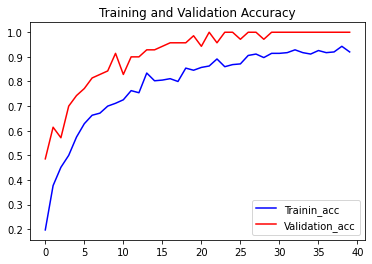

In [18]:
plt.plot(epochs,acc,label='Trainin_acc',color='blue')
plt.plot(epochs,val_acc,label='Validation_acc',color='red')
plt.legend()
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation loss')

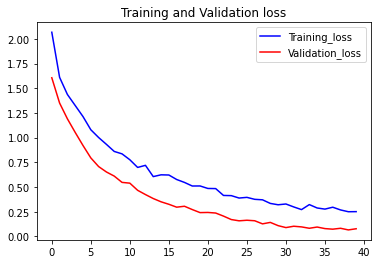

In [19]:
plt.plot(epochs,loss,label='Training_loss',color='blue')
plt.plot(epochs,val_loss,label='Validation_loss',color='red')
plt.legend()
plt.title("Training and Validation loss")

In [20]:
training_set.class_indices

{'biotite': 0,
 'bornite': 1,
 'chrysocolla': 2,
 'malachite': 3,
 'muscovite': 4,
 'pyrite': 5,
 'quartz': 6}

In [21]:
class_dict = {0: 'biotite',
 1: 'bornite',
 2:'chrysocolla',
 3: 'malachite',
 4: 'muscovite',
 5: 'pyrite',
 6: 'quartz'}

biotite


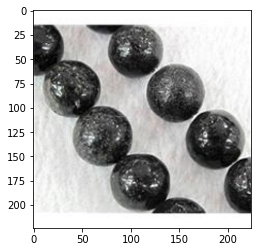

In [22]:
file_path =  'minet/test/biotite/0001.jpg'
test_image = cv2.imread(file_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_CUBIC)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)
probs = model.predict(test_image)
pred_class = np.argmax(probs)

pred_class = class_dict[pred_class]
print(pred_class)

bornite


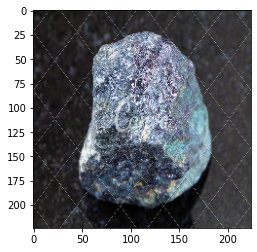

In [23]:
file_path =  'minet/test/bornite/0010.jpg'
test_image = cv2.imread(file_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_CUBIC)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)
probs = model.predict(test_image)
pred_class = np.argmax(probs)

pred_class = class_dict[pred_class]
print(pred_class)

malachite


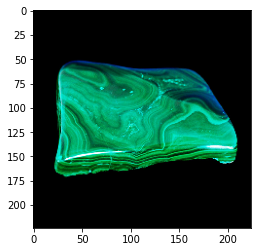

In [24]:
file_path =  'minet/test/malachite/0008.jpg'
test_image = cv2.imread(file_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_CUBIC)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)
probs = model.predict(test_image)
pred_class = np.argmax(probs)

pred_class = class_dict[pred_class]
print(pred_class)

In [25]:
model.save("Mineral.h5")

In [26]:
!deepCC Mineral.h5

reading [keras model] from 'Mineral.h5'
Saved 'Mineral.onnx'
reading onnx model from file  Mineral.onnx
Model info:
  ir_vesion :  5 
  doc       : 
WARN (ONNX): graph-node block1_conv1's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block1_conv2's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block2_conv1's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block2_conv2's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block3_conv1's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block3_conv2's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block3_conv3's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block4_conv1's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block4_conv2's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block4_conv3's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block5_